# Zadanie domowe -- interpolacja dwusześcienna

Interpolacja dwusześcienna, to podobnie jak w przypadku interpolacji dwuliniowej, rozszerzenie idei interpolacji jednowymiarowej na dwuwymiarową siatkę.
W trakcie jej obliczania wykorzystywane jest 16 pikseli z otoczenia (dla dwuliniowej 4).
Skutkuje to zwykle lepszymi wynikami - obraz wyjściowy jest bardziej gładki i z mniejszą liczbą artefaktów.
Ceną jest znaczny wzrost złożoności obliczeniowej (zostało to zaobserwowane podczas ćwiczenia).

Interpolacja dana jest wzorem:
\begin{equation}
I(i,j) = \sum_{i=0}^{3} \sum_{j=0}^{3} a_{ij} x^i y^j
\end{equation}

Zadanie sprowadza się zatem do wyznaczenia 16 współczynników $a_{ij}$.
W tym celu wykorzystuje się, oprócz wartość w~puntach $A$ (0,0), $B$ (1 0), $C$ (1,1), $D$ (0,1) (por. rysunek dotyczący interpolacji dwuliniowej), także pochodne cząstkowe $A_x$, $A_y$, $A_{xy}$.
Pozwala to rozwiązać układ 16-tu równań.

Jeśli zgrupujemy parametry $a_{ij}$:
\begin{equation}
a = [ a_{00}~a_{10}~a_{20}~a_{30}~a_{01}~a_{11}~a_{21}~a_{31}~a_{02}~a_{12}~a_{22}~a_{32}~a_{03}~a_{13}~a_{23}~a_{33}]
\end{equation}

i przyjmiemy:
\begin{equation}
x = [A~B~D~C~A_x~B_x~D_x~C_x~A_y~B_y~D_y~C_y~A_{xy}~B_{xy}~D_{xy}~C_{xy}]^T
\end{equation}

To zagadnienie można opisać w postaci równania liniowego:
\begin{equation}
Aa = x
\end{equation}
gdzie macierz $A^{-1}$ dana jest wzorem:

\begin{equation}
A^{-1} =
\begin{bmatrix}
1& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0 \\
0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
-3&  3&  0&  0& -2& -1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
2& -2&  0&  0&  1&  1&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  0&  1&  0&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0& -3&  3&  0&  0& -2& -1&  0&  0 \\
0&  0&  0&  0&  0&  0&  0&  0&  2& -2&  0&  0&  1&  1&  0&  0 \\
-3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0& -3&  0&  3&  0&  0&  0&  0&  0& -2&  0& -1&  0 \\
9& -9& -9&  9&  6&  3& -6& -3&  6& -6&  3& -3&  4&  2&  2&  1 \\
-6&  6&  6& -6& -3& -3&  3&  3& -4&  4& -2&  2& -2& -2& -1& -1 \\
2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0&  0&  0&  0&  0 \\
0&  0&  0&  0&  2&  0& -2&  0&  0&  0&  0&  0&  1&  0&  1&  0 \\
-6&  6&  6& -6& -4& -2&  4&  2& -3&  3& -3&  3& -2& -1& -2& -1 \\
4& -4& -4&  4&  2&  2& -2& -2&  2& -2&  2& -2&  1&  1&  1&  1 \\
\end{bmatrix}
\end{equation}

Potrzebne w rozważaniach pochodne cząstkowe obliczane są wg. następującego przybliżenia (przykład dla punktu A):
\begin{equation}
A_x = \frac{I(i+1,j) - I(i-1,j)}{2}
\end{equation}
\begin{equation}
A_y = \frac{I(i,j+1) - I(i,j-1)}{2}
\end{equation}
\begin{equation}
A_xy = \frac{I(i+1,j+1) - I(i-1,j) - I(i,j-1) + I(i,j)}{4}
\end{equation}

## Zadanie

Wykorzystując podane informacje zaimplementuj interpolację dwusześcienną.
Uwagi:
- macierz $A^{-1}$ dostępna jest w pliku *a_invert.py*
- trzeba się zastanowić nad potencjalnym wykraczaniem poza zakres obrazka (jak zwykle).

Ponadto dokonaj porównania liczby operacji arytmetycznych i dostępów do pamięci koniecznych przy realizacji obu metod interpolacji: dwuliniowej i dwusześciennej.

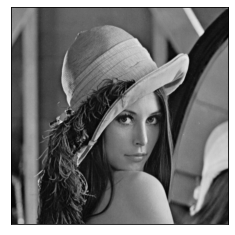

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import math
from timeit import default_timer as timer
import sympy
np.seterr(over='ignore')
        
def pochodna(M, X, Y, I):
    A = np.zeros(4,dtype = 'uint8')
    befx = M[0] - 1

    if befx == 0:
        befx = 1

    aftx = M[1] + 1
    if aftx >= X:
        aftx = X
        
    befy = M[0] - 1
    if befy == 0:
        befy = 1

    afty = M[1] + 1
    if afty >= Y:
        afty = Y
    
    A[0] = I[M[0],M[1]]
    A[1] = (I[aftx, M[1]] - I[befx, M[1]]) / 2
    A[2] = (I[M[0], afty] - I[M[0], befy]) / 2
    A[3] = ((I[aftx, afty] - I[befx, M[1]]) - I[M[0], befy] + I[M[0], M[1]]) / 4
    
    return A
    

def dwuszescienna(I, sx, sy):
    X,Y = I.shape
    Xs = int(X*sx)
    Ys = int(Y*sy)    
    Is = np.zeros([Xs,Ys])
    
    A_inv = np.array([[1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\
        [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0 ],\
        [-3,  3,  0,  0, -2, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0 ],\
        [2, -2,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0 ],\
        [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0 ],\
        [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0 ],\
        [0,  0,  0,  0,  0,  0,  0,  0, -3,  3,  0,  0, -2, -1,  0,  0 ],\
        [0,  0,  0,  0,  0,  0,  0,  0,  2, -2,  0,  0,  1,  1,  0,  0 ],\
        [-3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0,  0,  0,  0,  0 ],\
        [0,  0,  0,  0, -3,  0,  3,  0,  0,  0,  0,  0, -2,  0, -1,  0 ],\
        [9, -9, -9,  9,  6,  3, -6, -3,  6, -6,  3, -3,  4,  2,  2,  1 ],\
        [-6,  6,  6, -6, -3, -3,  3,  3, -4,  4, -2,  2, -2, -2, -1, -1 ],\
        [2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0 ],\
        [0,  0,  0,  0,  2,  0, -2,  0,  0,  0,  0,  0,  1,  0,  1,  0 ],\
        [-6,  6,  6, -6, -4, -2,  4,  2, -3,  3, -3,  3, -2, -1, -2, -1 ],\
        [4, -4, -4,  4,  2,  2, -2, -2,  2, -2,  2, -2,  1,  1,  1,  1 ]])
    
    for i in range(0, Xs):
        for j in range(0, Ys):
            ix = math.floor( i / sx)
            jy = math.floor( j / sy)
            
            A = [ix, jy]
            B = [ix, jy + 1]
            C = [ix + 1 , jy + 1]
            D = [ix + 1, jy]
            
            if B[1] >= Y:
                B[1] = Y - 1
                
            if C[0] >= X:
                C[0] = X - 1
            
            if C[1] >= Y:
                C[1] = Y - 1
            
            if D[0] >= X:
                D[0] = X - 1

            iu = int((i/sx) - ix)
            ju = int((j/sy) - jy)
            

            A2 = pochodna(A, iu, ju, I)
            B2 = pochodna(B, iu, ju, I)
            C2 = pochodna(C, iu, ju, I)
            D2 = pochodna(D, iu, ju, I)
                
            x = np.array([A2[0], A2[1], A2[2], A2[3], B2[0], B2[1], B2[2], B2[3], \
                 C2[0], C2[1], C2[2], C2[3], D2[0], D2[1], D2[2], D2[3]])
            
            xt = np.transpose(x)
            M = np.dot(A_inv,xt)
            M_4 = np.array([[M[0], M[4], M[8], M[12]],[M[1], M[5], M[9], M[13]],  [M[2], M[6], M[10], M[14]],[M[3], M[7], M[11], M[15]]], ndmin=2)

            l = np.array([1,iu, iu*iu, iu*iu*iu])
            r = np.array([1,ju, ju*ju, ju*ju*ju]).T
            
            newPix = np.dot(l,M_4)
            newPix = np.dot(newPix,r)       
                        
            Is[i,j] = newPix
            
    return Is
  

I = cv2.imread('lena.bmp')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)


plt.imshow(dwuszescienna(I,2,2))
plt.xticks([]), plt.yticks([])
plt.gray()
plt.show()